In [1]:
import sys
import os
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import math
import pandas as pd
import sklearn
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [2]:
#--------------------------------------------------------#
main = os.getcwd() + '\\data_sets'
vocab = np.loadtxt('dictionary.txt', str).tolist()


def get_y_labels(pos, neg):
    '''
    Params:
        pos (str): path to positive directory
        neg (str): path to negative directory
    Returns:
        (array) encoded class labels in order
    
    '''
    pos = np.ones(len(pos))
    neg = np.zeros(len(neg))
    return np.concatenate([pos, neg])

def fetch_files(main_path):
    '''
    Params:
        None
    Returns:
        4 lists containing all absolute paths to train and test sets
            train_pos
            train_neg
            test_pos
            test_neg
    '''
    train_path = main + '\\training_set'
    test_path = main + '\\test_set'

    train_pos = train_path + '\\' + os.listdir(train_path)[1] + '\\'
    train_neg = train_path + '\\' + os.listdir(train_path)[0] + '\\'
    test_pos = test_path + '\\' + os.listdir(test_path)[1] + '\\'
    test_neg = test_path + '\\' + os.listdir(test_path)[0] + '\\'
    
    f = lambda x: [x + os.listdir(x)[i] for i in range(0,len(os.listdir(x)))]
    train_pos = f(train_pos)
    train_neg = f(train_neg)
    test_pos = f(test_pos)
    test_neg = f(test_neg)

    return train_pos, train_neg, test_pos, test_neg


#--------------------------------------------------------#

def transfer(fileDj, vocabulary, love_replace = True):
    file = np.loadtxt(fileDj, delimiter='\n', dtype=str)
    BOWDj = [0] * len(vocabulary)
    for i,p in enumerate(vocabulary):
        for j in file:
            if love_replace:
                j = j.replace("loved", "love")
                j = j.replace("loves", "love")
                j = j.replace("loving", "love")
            tokens = j.split()
            for k in tokens:
                if p == k:
                    BOWDj[i] += 1
                else:
                    BOWDj[-1] += 1

    return BOWDj


def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    return ''.join(x)                                     # join the list
    
def stem(x):
    ps = PorterStemmer()
    x = ps.stem(x)
    return x

    
#--------------------------------------------------------#
def loadData(Path, vocab):
    '''
    Params:
        Path - Main Path
    Returns:
        4 lists containing all absolute paths to train and test sets
            train_pos
            train_neg
            test_pos
            test_neg
    '''

    train_pos, train_neg, test_pos, test_neg = fetch_files(
        main_path=Path)  #used fetch_files under the hood

    ytrain = get_y_labels(train_pos, train_neg)  #fetch train labels
    ytest = get_y_labels(test_pos, test_neg)  #fetch test labels
    Xtrain = {}
    for i,j in enumerate(train_pos + train_neg):
        Xtrain[i] = transfer(j, vocabulary=vocab)

    Xtest = {}
    for i,j in enumerate(test_pos + test_neg):
        Xtest[i] = transfer(j, vocabulary=vocab)

    convert_to_df = lambda x: pd.DataFrame.from_dict(x).T
    Xtrain = convert_to_df(Xtrain)
    Xtest = convert_to_df(Xtest)

    Xtrain.columns = vocab
    Xtest.columns = vocab

    return Xtrain, Xtest, ytrain, ytest


#--------------------------------------------------------#
def naiveBayesMulFeature_train(Xtrain, ytrain, alpha = 1):

    pos = Xtrain[:700] #split
    neg = Xtrain[700:] #split
    thetaPos = []
    thetaNeg = []
    for i in pos.columns:
        temp = math.log((pos[i].sum() + alpha) / (sum(pos.sum()) + (alpha + len(pos.columns)))) 
        thetaPos.append(temp)
    for i in neg.columns:
        temp = math.log((neg[i].sum() + alpha) / (sum(neg.sum()) + (alpha + len(neg.columns))))
        thetaNeg.append(temp)

    return thetaPos, thetaNeg


#--------------------------------------------------------#
def naiveBayesMulFeature_test(Xtest, ytest, thetaPos, thetaNeg):
    pos_lu =dict(zip(vocab, thetaPos))
    neg_lu  =dict(zip(vocab, thetaNeg))
    yPredict = []
    for i in range(0, len(Xtest)): #each test instance
        test = dict(Xtest.loc[i])
        words = { k: v for k, v in test.items() if v > 0 }
        pos = 0
        neg = 0
        for i,j in words.items():
            pos += pos_lu[i] * j
            neg += neg_lu[i] * j
        #Thresholds for class mapping    
        yPredict.append(np.argmax([neg,pos]))

            
    Accuracy = np.sum(yPredict == ytest) / len(ytest) 
    return yPredict, Accuracy
#--------------------------------------------------------#
def naiveBayesMulFeature_sk_MNBC(Xtrain, ytrain, Xtest, ytest):
    model = sklearn.naive_bayes.MultinomialNB(fit_prior= False)
    model.fit(Xtrain, ytrain)
    yPredict = model.predict(Xtest)
    Accuracy = np.sum(ytest == yPredict) / len(ytest) 
    return Accuracy
#--------------------------------------------------------#
def naiveBayesBernFeature_train(Xtrain, ytrain):
    pos = Xtrain[:700] #split
    neg = Xtrain[700:] #split
    thetaPosTrue = []
    thetaNegTrue = []
    
    for i in pos.columns:
        temp = ((pos[i].astype(bool).sum(axis=0) + 1) / (len(pos) + 
                                                  2))
        thetaPosTrue.append(temp)
    for i in neg.columns:
        temp = (neg[i].astype(bool).sum(axis=0) + 1) / (len(neg) + 
                                                  2)
        thetaNegTrue.append(temp)

    return thetaPosTrue, thetaNegTrue
#--------------------------------------------------------#
def naiveBayesBernFeature_test(Xtest, ytest, thetaPosTrue, thetaNegTrue):
    
    yPredict = []
    for i in range(0, len(Xtest)): #each test instance
        pos = 0.5
        neg = 0.5
        a = np.array(Xtest.loc[i])
        for i in range(0, 101):
            if a[i] > 0:
                pos+= math.log(thetaPosTrue[i])
                neg += math.log(thetaNegTrue[i])
            elif a[i] == 0:
                pos+= math.log(1 - thetaPosTrue[i])
                neg += math.log(1 - thetaNegTrue[i])
        
        #Thresholds for class mapping    
        yPredict.append(np.argmax([neg,pos]))

            
    Accuracy = np.sum(yPredict == ytest) / len(ytest) 
    return yPredict, Accuracy

def ntlk_get_data(x,y): 
    storage = []
    for i,j in enumerate(x + y):
        main = ''
        text = np.loadtxt(j, delimiter='\n', dtype=str)
        for l in text:
            main += l
        storage.append(main)
    return storage
    
def nltk_pipe(max_feats, gram):
    main = os.getcwd() + '\\data_sets'

    train_pos, train_neg, test_pos, test_neg = fetch_files(
            main_path=main)  #used fetch_files under the hood
    
    train = ntlk_get_data(train_pos, train_neg)
    test = ntlk_get_data(test_pos, test_neg)


    stop_words = set(stopwords.words('english')) 
    
    Xtrain = pd.DataFrame(train)
    Xtest = pd.DataFrame(test)
    Xtrain.columns = ['doc']
    Xtest.columns = ['doc']
    
    remove_stopwords = lambda x: x['doc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    clean_text = lambda x: x['doc'].apply(preprocess)
    stem_df = lambda x: x['doc'].apply(stem)

    Xtrain.columns = ['doc']
    Xtest.columns = ['doc']
    
    Xtrain['doc'] = remove_stopwords(Xtrain)
    Xtrain['doc'] = clean_text(Xtrain)
    Xtrain['doc'] = stem_df(Xtrain)

    Xtest['doc'] = remove_stopwords(Xtest)
    Xtest['doc'] = clean_text(Xtest)
    Xtest['doc'] = stem_df(Xtest)

    ytrain = get_y_labels(train_pos, train_neg)  #fetch train labels
    ytest = get_y_labels(test_pos, test_neg) 
    vec = CountVectorizer(max_features= max_feats, ngram_range= (gram, gram))
    Xtrain = vec.fit_transform(Xtrain['doc'])
    Xtest = vec.transform(Xtest['doc'])
    ytrain = get_y_labels(train_pos, train_neg)  #fetch train labels
    ytest = get_y_labels(test_pos, test_neg) 


    Xtrain = pd.DataFrame(Xtrain.toarray(), columns= vec.get_feature_names())
    Xtest = pd.DataFrame(Xtest.toarray(), columns= vec.get_feature_names())

    return naiveBayesMulFeature_sk_MNBC(Xtrain, ytrain, Xtest, ytest)

In [6]:
#Xtrain, Xtest, ytrain, ytest = loadData(Path = main, vocab = vocab, nltk_pre = False)
Xtrain, Xtest, ytrain, ytest = loadData(Path= main, vocab=vocab)
thetaPos, thetaNeg = naiveBayesMulFeature_train(Xtrain, ytrain, alpha =  1)
thetaPosTrue, thetaNegTrue = naiveBayesBernFeature_train(Xtrain, ytrain)
print('----------------Multinomial Naive Bayes---------------------------')
print('my accuracy:' ,np.round(naiveBayesMulFeature_test(Xtest, ytest, thetaPos, thetaNeg)[1],3) *100) 
print('sklearn accuracy:', np.round(naiveBayesMulFeature_sk_MNBC(Xtrain, ytrain, Xtest, ytest),3)*100) 
print('----------------Multivariate Bernoulli Naive Bayes---------------------------')
print('my accuracy:' , naiveBayesBernFeature_test(Xtest, ytest, thetaPosTrue, thetaNegTrue)[1])

----------------Multinomial Naive Bayes---------------------------
my accuracy: 76.5
sklearn accuracy: 76.5
----------------Multivariate Bernoulli Naive Bayes---------------------------
my accuracy: 0.735


In [5]:
naiveBayesBernFeature_test(Xtest, ytest, thetaPosTrue, thetaNegTrue)[1]

0.735

In [157]:
thetaNeg, thetaPos = model.feature_log_prob_

yPredict = []
for i in range(0, len(Xtest)): #each test instance
    words = list(np.nonzero(Xtest.loc[i].values)[0])
    pos_prob = np.sum([thetaPos[j] for j in words]) 
    neg_prob = np.sum([thetaNeg[j] for j in words]) 
    #Thresholds for class mapping    
    if pos_prob > neg_prob:
        yPredict.append(1)
    elif pos_prob < neg_prob:
        yPredict.append(0)
    else:
        yPredict.append(1)


Accuracy = np.sum(yPredict == ytest) / len(ytest) 
Accuracy

0.7366666666666667

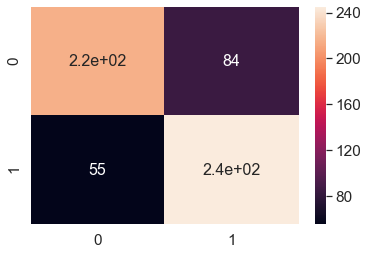

              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76       300
         1.0       0.74      0.82      0.78       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600



In [176]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(ytest,preds)

df_cm = pd.DataFrame(cm, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

plt.show()

print(sklearn.metrics.classification_report(ytest, preds))

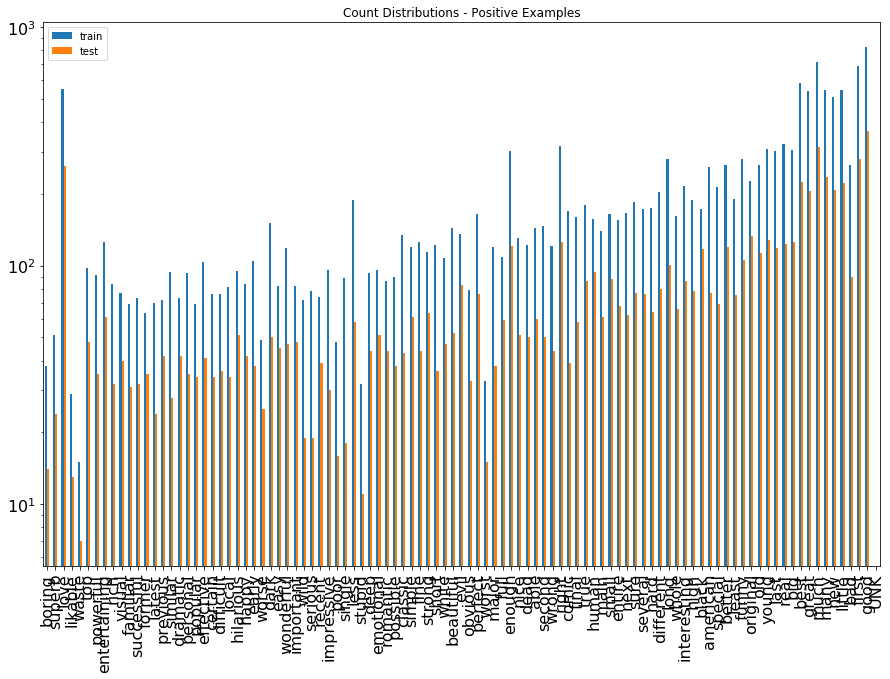

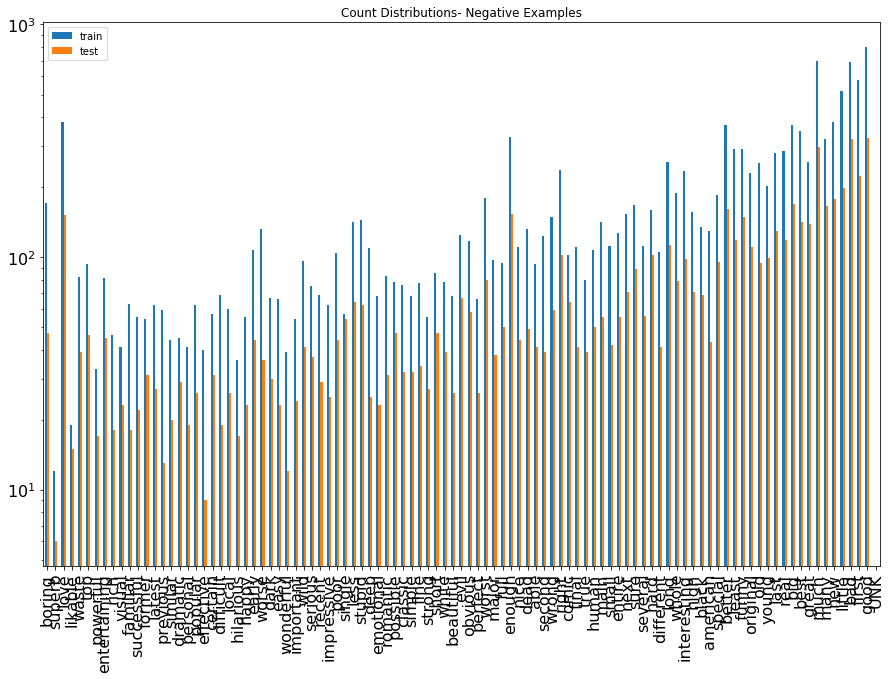

In [144]:
df = pd.DataFrame([Xtrain[:700].T.sum(axis = 1), Xtest[:300].T.sum(axis = 1)]).T
df.columns = ['train', 'test']
df[['train', 'test']].plot(kind='bar', title ="Count Distributions - Positive Examples", figsize=(15, 10), legend=True, fontsize=16, logy= True)

df = pd.DataFrame([Xtrain[700:].T.sum(axis = 1), Xtest[300:].T.sum(axis = 1)]).T
df.columns = ['train', 'test']
df[['train', 'test']].plot(kind='bar', title ="Count Distributions- Negative Examples", figsize=(15, 10), legend=True, fontsize=16, logy= True)

In [229]:
acc = [] 
for i in [2,4,8,16,32,64,128,256, 512,1024,2048,4096,8192,16384]:
    acc.append(np.round(nltk_pipe(max_feats = i, gram = (1,1)), 2))
    print('NLTK Preprocessing Test Accuracy {}-features:'.format(i), np.round(nltk_pipe(max_feats = i), 2))

TypeError: can only concatenate tuple (not "int") to tuple

In [214]:
feats = [2,4,8,16,32,64,128,256, 512,1024,2048,4096,8192,16384]
sns.lineplot(feats, acc)
plt.xlabel('# of Features')
plt.ylabel('Test Accuracy')

ValueError: arrays must all be same length